In [1]:
%%html
<style>
.container{width:85%}
<style>

In [ ]:
!conda install -c frankong sigpy

In [2]:
import RL_samp
from RL_samp.header import *
from RL_samp.utils import *
from RL_samp.replay_buffer import *
from RL_samp.models import poly_net, val_net
from RL_samp.reconstructors import unet_solver
from RL_samp.policies import DQN
from RL_samp.trainers import DeepQL_trainer #, AC1_ET_trainer

from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import colors
import torch.nn.functional as Func

def rolling_mean(x,window):
    window = int(window)

    # Stephen: for large data, the above gets a bit slow, so we can do this:
#   y = np.convolve(x, np.ones(window)/window, mode='valid')
#   return y
    # or https://stackoverflow.com/a/27681394
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

# data

In [ ]:
fs_dataloader = dataloader()

In [ ]:
fs_dataloader.load()

In [ ]:
train_percentage = 0.75

datapath = '/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".pt") and file.startswith('fs'):
        ncfiles.append(file)
print('debug: ncfiles[0] is ', ncfiles[0])
print('Number of useful files: ', len(ncfiles))
random.shuffle(ncfiles)
print('debug: ncfiles[0] is ', ncfiles[0])
train_file_num = int(np.ceil(train_percentage*len(ncfiles)))

train_files = ncfiles[0:train_file_num]
print('Number of Train  files: ', len(train_files))
test_files = ncfiles[train_file_num:]
print('Number of Test   files: ', len(test_files))

In [ ]:
np.savez('/home/ec2-user/SageMaker/RLsamp/train_files.npz',files=train_files)
np.savez('/home/ec2-user/SageMaker/RLsamp/test_files.npz', files=test_files)

In [ ]:
datapath = '/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".pt") and file.startswith('fs'):
        ncfiles.append(file)

In [12]:
# useful_files = np.load('/home/ec2-user/SageMaker/RLsamp/useful_files.npz', allow_pickle=True)['files']
train_files  = np.load('/home/ec2-user/SageMaker/RLsamp/train_files.npz', allow_pickle=True)['files']
test_files   = np.load('/home/ec2-user/SageMaker/RLsamp/test_files.npz', allow_pickle=True)['files']

In [4]:
time_dim = [[],[]]
slice_dim = [[],[]]
rep_dim = [[],[]]
for row in useful_files:
    if row[0].startswith('fs'):
        if (row[0][:-3] + '.pt') in train_files:
            time_dim[0].append(row[1][4])
            slice_dim[0].append(row[1][6])
            rep_dim[0].append(row[1][7])
        if (row[0][:-3] + '.pt') in test_files:
            time_dim[1].append(row[1][4])
            slice_dim[1].append(row[1][6])
            rep_dim[1].append(row[1][7])

In [5]:
sorted(rep_dim[1])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [6]:
print('train: ',train_files, len(train_files) )
print('test: ', test_files, len(test_files) )

train:  ['fs_0069_1_5T.pt' 'fs_0011_1_5T.pt' 'fs_0072_1_5T.pt' 'fs_0019_3T.pt'
 'fs_0057_1_5T.pt' 'fs_0043_3T.pt' 'fs_0037_3T.pt' 'fs_0009_1_5T.pt'
 'fs_0039_3T.pt' 'fs_0030_3T.pt' 'fs_0034_3T.pt' 'fs_0061_1_5T.pt'
 'fs_0045_3T.pt' 'fs_0070_1_5T.pt' 'fs_0059_1_5T.pt' 'fs_0024_3T.pt'
 'fs_0033_3T.pt' 'fs_0010_1_5T.pt' 'fs_0028_3T.pt' 'fs_0022_3T.pt'
 'fs_0036_3T.pt' 'fs_0067_1_5T.pt' 'fs_0007_1_5T.pt' 'fs_0027_3T.pt'
 'fs_0046_3T.pt' 'fs_0032_3T.pt' 'fs_0029_3T.pt' 'fs_0040_3T.pt'
 'fs_0031_3T.pt' 'fs_0073_1_5T.pt' 'fs_0026_3T.pt' 'fs_0044_3T.pt'
 'fs_0020_3T.pt'] 33
test:  ['fs_0038_3T.pt' 'fs_0060_1_5T.pt' 'fs_0058_1_5T.pt' 'fs_0035_3T.pt'
 'fs_0023_3T.pt' 'fs_0074_1_5T.pt' 'fs_0041_3T.pt' 'fs_0025_3T.pt'
 'fs_0042_3T.pt' 'fs_0021_3T.pt'] 10


In [14]:
IMG_COUNT = 0
for file in train_files:
    data = torch.load(f'/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/{file}')
    print(data.shape)
    IMG_COUNT += np.prod(data.shape[2:])
print('train image count: ', IMG_COUNT)

torch.Size([192, 144, 1, 25, 1, 12, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 20, 1, 1, 1])
torch.Size([192, 144, 1, 25, 1, 1, 1])
torch.Size([192, 144, 1, 25, 1, 12, 1])
torch.Size([192, 144, 1, 18, 1, 1, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 16, 1, 1, 1])
torch.Size([192, 144, 1, 26, 1, 1, 1])
torch.Size([192, 144, 1, 18, 1, 1, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 25, 1, 10, 1])
torch.Size([192, 144, 1, 25, 1, 1, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 18, 1, 1, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 28, 1, 1, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 17, 1, 1, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 23, 1, 1, 1])
torch.Size([192, 144, 1, 28, 1, 1, 1])
torch.Size([192, 144, 1, 25, 1, 1, 1])
torch.Size([192, 144, 

In [13]:
IMG_COUNT = 0
for file in test_files:
    data = torch.load(f'/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/{file}')
    print(data.shape)
    IMG_COUNT += np.prod(data.shape[2:])
print('test image count: ', IMG_COUNT)

torch.Size([192, 144, 1, 16, 1, 1, 1])
torch.Size([192, 144, 1, 21, 1, 12, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 18, 1, 1, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
torch.Size([192, 144, 1, 19, 1, 12, 1])
torch.Size([192, 144, 1, 18, 1, 1, 1])
torch.Size([192, 144, 1, 27, 1, 1, 1])
torch.Size([192, 144, 1, 17, 1, 1, 1])
torch.Size([192, 144, 1, 22, 1, 1, 1])
test image count:  642


# dev

In [ ]:
### DQN Parameter settings

## image parameters
heg = 192
wid = 144

## reconstructor parameters
max_iter = 50
L = 5e-3
solver = 'ADMM'

## trainer parameters
discount    = .5
memory_len  = 20
t_backtrack = 3
base        = 5
budget      = 13
episodes    = 1
save_freq   = 10
batch_size  = 2
ngpu        = 1
lr          = 1e-3
eps         = 1e-3
double_q    = False

In [ ]:
reload(RL_samp)
import RL_samp
import RL_samp.trainers
from RL_samp.trainers import DeepQL_trainer


In [ ]:
loader  = ocmrLoader(ncfiles,batch_size=1,t_backtrack=t_backtrack)
memory  = ReplayMemory(capacity=memory_len,
                       curr_obs_shape=(t_backtrack,heg,wid),
                       mask_shape=(wid),
                       next_obs_shape=(1,heg,wid),
                       batch_size=batch_size,
                       burn_in=batch_size)
model   = poly_net(samp_dim=wid)
policy  = DQN(model,memory,max_iter=max_iter,ngpu=ngpu,gamma=discount,lr=lr,double_q_mode=double_q,
              solver=solver,max_iter=max_iter,L=L)
trainer = DeepQL_trainer(loader,policy,episodes=episodes,
                         eps=eps,
                         base=base,budget=budget,
                         ngpu=ngpu)
trainer.train()

In [ ]:
### AC1 Parameter settings

## image parameters
heg = 192
wid = 144

## reconstructor parameters
max_iter = 50
L = 5e-3
solver = 'ADMM'

## trainer parameters
discount    = .9
t_backtrack = 3
base        = 5
budget      = 13
episodes    = 1
save_freq   = 10
batch_size  = 2
ngpu        = 0
lr          = 1e-3
eps         = 1e-3
double_q    = False

In [ ]:
reload(RL_samp)
import RL_samp
from RL_samp.trainers import AC1_trainer

In [ ]:
loader  = ocmrLoader(ncfiles,batch_size=1,t_backtrack=t_backtrack)
p_net   = poly_net(samp_dim=wid,softmax=True)
v_net   = val_net()
trainer = AC1_trainer(loader, polynet=p_net, valnet=v_net,
                      base=base, budget=budget,
                      gamma=discount,
                      lr=lr,
                      solver=solver, max_iter=max_iter, L=L,
                      ngpu=ngpu)
trainer.run()

In [ ]:
loader  = ocmrLoader(ncfiles,batch_size=1,t_backtrack=t_backtrack)
p_net   = poly_net(samp_dim=wid,softmax=True)
v_net   = val_net(slope=.5,scale=10)
trainer = AC1_ET_trainer(loader, polynet=p_net, valnet=v_net,
                      base=base, budget=budget,
                      gamma=discount,
                      solver=solver, max_iter=max_iter, L=L, reward_scale=9e2,
                      ngpu=ngpu)

In [ ]:
trainer.run()

## find probability distribution of training dataset

In [ ]:
train_files = np.load('/home/ec2-user/SageMaker/RLsamp/train_files.npz')['files']
t_backtrack = 8
loader      = ocmrLoader(train_files,batch_size=1,datapath='/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/',
                         t_backtrack=t_backtrack,train_mode=False)
loader.reset()

In [ ]:
def compute_density(imgs,fix=8,fft_input=False):
    '''
    input imgs: [NCHW]
    '''
    fix   = int(fix)
    [N,C,_,sampdim] = imgs.shape
    if not fft_input:
        y = F.fftn(imgs,dim=(2,3),norm='ortho')
    else:
        y = imgs
    p = torch.sum(torch.abs(y),axis=(0,1,2))/(N*C)
    fixInds  = np.concatenate((np.arange(0,round(fix//2) ),np.arange(sampdim-1,sampdim-1-round(fix/2),-1)))
    p[fixInds] = 0
    p = p/p.sum() # normalize probability vector
    
    return p

In [ ]:
x, _ = loader.load()
sampdim   = 144
IMG_COUNT = 0
density   = torch.zeros(sampdim)
while x is not None:
    [N,C,_,_] = x.shape
    p_tmp = compute_density(x, fix=8, fft_input=False)
    density = (density* IMG_COUNT + p_tmp * N * C)/(IMG_COUNT+N*C)
    IMG_COUNT = IMG_COUNT + N*C
    x, _ = loader.load()

In [ ]:
save_dir = '/home/ec2-user/SageMaker/RLsamp/output/probdist_train_base_8.pt'
torch.save({"probability_density_base_8":density},save_dir)

## view training history: DDQN

In [ ]:
hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/DQN_doubleQ_True_ba8_bu16_hist_2023-04-10_BA8BU16_LF_0G_600Epochs.pt'
data = torch.load(hist_dir)
print(data.keys())

In [ ]:
## Loss Convergence Plot
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure()
window_small = 400
num_ticks = 6
epochs = 600
sequence_length = len(rolling_mean(data['training_record']['rmse'],window_small))

plt.plot(rolling_mean(data['training_record']['rmse'],window_small), linewidth=0.8, label='DDQN')
plt.plot(rolling_mean(data['training_record']['rmse_rand'],window_small), linestyle=':', linewidth=.5,  label='rand.')
plt.plot(rolling_mean(data['training_record']['rmse_lowfreq'],window_small), linestyle='--', linewidth=.5,  label='lowfreq.')
plt.xticks(ticks=np.arange(0, sequence_length, sequence_length//num_ticks), labels=[epochs//num_ticks * i for i in range(0,num_ticks+1)],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel(r'Normalized $\ell_2$ error', fontsize=20)
plt.legend(loc='best',fontsize=13)
# figname = './figures/DDQN_RMSE_convergence_plot.pdf'
# plt.savefig(figname, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
## make mask convergence plots
sampdim = 144
TOTAL_PTS = 700

T  = len(data['training_record']['recon_samples'])
t0 = 0
t1 = 0

Ts1 = np.arange(t0,t1,1) 
Ts2 = np.linspace(t1, T-1, TOTAL_PTS - (t1-t0)).astype(int)
Ts  = list(Ts1) + list(Ts2)
series = [data['training_record']['recon_samples'][t] for t in Ts]
masks = [item[2] for item in series]
mask_mat = torch.zeros(sampdim,len(Ts))
for ind in range(len(Ts)):
    mask_mat[:,ind] = F.fftshift(masks[ind])

In [ ]:
plt.clf()
plt.figure(figsize=(20,3))
label_fontsize = 20
plt.imshow(mask_mat,origin='lower',cmap='Greys')
# plt.xlabel('time',fontsize=label_fontsize)
# plt.ylabel('frequencies',fontsize=label_fontsize)
plt.yticks([],[])

if t1 > t0:
    plt.xticks([len(Ts1)],[r'$t_\ast$'],fontsize=15)
else:
    plt.xticks([],[])
    
figname = '/home/ec2-user/SageMaker/RLsamp/figures/DDQN_mask.pdf'
plt.savefig(figname, bbox_inches='tight', 
               transparent=True)
plt.show()

In [ ]:
# hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/EVAL_DQN_doubleQ_True_ba8_bu16_2023-05-02.pt'
hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/EVAL_DQN_doubleQ_True_ba8_bu16_2023-05-08.pt'
data = torch.load(hist_dir)
print(data.keys())
print(data['testing_record'].keys())

In [ ]:
print('DDQN rmse test: ', np.mean(data['testing_record']['rmse']))
print('Rand. rmse test    : ', np.mean(data['testing_record']['rmse_rand']))
print('LowFreq. rmse test : ', np.mean(data['testing_record']['rmse_lowfreq']))
print('\n')
print('DDQN rmse test: ', np.mean(data['testing_record']['ssim']))
print('Rand. rmse test    : ', np.mean(data['testing_record']['ssim_rand']))
print('LowFreq. rmse test : ', np.mean(data['testing_record']['ssim_lowfreq']))

In [ ]:
T = 22

series = data['testing_record']['recon_samples'][0:T]
gts    = [item[0].squeeze().cpu() for item in series]
recons = [item[1].squeeze().cpu() for item in series]

figsize = (10,40)
nrows = 6
ncols = 3
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)

window_large = 300
window_small = 300

frame = np.linspace(0,T-1,nrows).astype(int)
for i in range(nrows):
    axs[i,0].imshow(gts[frame[i]],vmin=0,vmax=1,cmap='gray')
    axs[i,1].set_title(fr'$t={frame[i]+1}$')
    axs[i,1].imshow(recons[frame[i]],vmin=0,vmax=1,cmap='gray')
    hdl = axs[i,2].imshow(abs(recons[frame[i]]-gts[frame[i]])/gts[frame[i]] , norm=colors.LogNorm(vmin=0.1,vmax=10), cmap='winter')
    fig.colorbar(hdl, ax=axs[i,2], location='right', anchor=(0, 0.5), shrink=0.5)

for i in range(nrows):
    for j in range(ncols):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
plt.subplots_adjust(wspace=.1, hspace=0)
plt.show()

In [ ]:
hist['horizon_rewards'] = [item.item() for item in hist['horizon_rewards']]

In [ ]:
figsize = (12,13)
keys = list(data['training_record'].keys())
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=figsize)

window_large = 500
window_small = 300

axs[0,0].plot(rolling_mean(data['training_record']['loss'], window_large))
axs[0,0].set_title('running loss')

axs[0,1].plot(rolling_mean(data['training_record']['rmse'],window_small), label='RL')
axs[0,1].plot(rolling_mean(data['training_record']['rmse_rand'],window_small), label='rand')
axs[0,1].plot(rolling_mean(data['training_record']['rmse_lowfreq'],window_small), label='lowfreq.')
axs[0,1].set_title('RMSE - recon')
axs[0,1].legend(loc='best')
# axs[0,1].set_yscale('log')

axs[0,2].plot(rolling_mean(data['training_record']['horizon_rewards'],window_small))
axs[0,2].set_title('Horizon Reward')
# axs[0,2].set_yscale('log')

axs[1,0].plot(rolling_mean(data['training_record']['q_values_mean'],window_large))
axs[1,0].set_title('Q values mean')


axs[1,1].plot(rolling_mean(data['training_record']['grad_norm'],window_large))
axs[1,1].set_title('Grad Norm')
axs[1,1].set_yscale('log')

axs[1,2].axis('off')

gt = axs[2,0].imshow(data['training_record']['recon_samples'][-1][0][0,0,:,:].cpu(), origin='lower')
axs[2,0].set_title('Target gt')
fig.colorbar(gt, ax=axs[2,0], location='right', anchor=(0, 0.3), shrink=0.7)

recon = axs[2,1].imshow(data['training_record']['recon_samples'][-1][1][0,0,:,:].cpu(), origin='lower')
axs[2,1].set_title('Recon')
fig.colorbar(recon, ax=axs[2,1], location='right', anchor=(0, 0.3), shrink=0.7)

rel_error = axs[2,2].imshow((data['training_record']['recon_samples'][-1][1][0,0,:,:].cpu() - data['training_record']['recon_samples'][-1][0][0,0,:,:].cpu())/data['training_record']['recon_samples'][-1][0][0,0,:,:].cpu(),
                            origin='lower', norm=colors.LogNorm())
axs[2,2].set_title('Relative Error')
fig.colorbar(rel_error, ax=axs[2,2], location='right', anchor=(0, 0.3), shrink=0.7)


plt.show()

In [ ]:
print(keys)

## view training history: Actor-Critic

In [ ]:
hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/AC1_ET_hist_base8_budget16_2023-04-14_tb8_BA8_BU16_200G_600E_magweg5_rwd1_val_1.pt'
data = torch.load(hist_dir)
print(data.keys())
print(data['training_record'].keys())

In [ ]:
figsize = (15,15)
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=figsize)

window_large = 300
window_small = 300

axs[0,0].plot(rolling_mean(data['training_record']['poly_loss'], window_large))
axs[0,0].set_title('policy network running loss')

axs[0,1].plot(rolling_mean(data['training_record']['val_loss'],window_small))
axs[0,1].set_title('Value network running loss')
# axs[0,2].set_yscale('log')

axs[0,2].plot(rolling_mean(data['training_record']['v'],window_small))
axs[0,2].set_title('running v value')

axs[1,0].plot(rolling_mean(data['training_record']['horizon_rewards'],window_large))
axs[1,0].set_title('Horizon Rewards')


axs[1,1].plot(rolling_mean(data['training_record']['poly_grad_norm'],window_large))
axs[1,1].set_title('polynet Grad Norm')
# axs[1,1].set_yscale('log')

axs[1,2].plot(rolling_mean(data['training_record']['val_grad_norm'],window_large))
axs[1,2].set_title('valnet Grad Norm')
axs[1,2].set_yscale('log')

axs[2,0].plot(rolling_mean(data['training_record']['rmse'],window_small), label='RL')
axs[2,0].plot(rolling_mean(data['training_record']['rmse_rand'],window_small), label='rand')
axs[2,0].plot(rolling_mean(data['training_record']['rmse_lowfreq'],window_small), label='lowfreq.')
axs[2,0].set_title('RMSE - recon')
axs[2,0].legend(loc='best')
# axs[0,1].set_yscale('log')

gt = axs[2,1].imshow(data['training_record']['recon_samples'][-1][0][0,0,:,:])
axs[2,1].set_title('Recon')
fig.colorbar(gt, ax=axs[2,1], location='right', anchor=(0, 0.3), shrink=0.7)

recon = axs[2,2].imshow(data['training_record']['recon_samples'][-1][1][0,0,:,:])
axs[2,2].set_title('Target gt')
fig.colorbar(recon, ax=axs[2,2], location='right', anchor=(0, 0.3), shrink=0.7)


plt.show()

## view training history: REINFORCE

In [ ]:
## view training history: DDQN
hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/REINFORCE_hist_2023-04-24_base8_budget16_BA8_BU16_E1000_G0_H1e-2_wTrue_magweg5_rwd1.pt'
data = torch.load(hist_dir)
print(data.keys())
print(data['training_record'].keys())

In [ ]:
## Loss Convergence Plot
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure()
window_small = 400
num_ticks = 6

epochs_total = 1000
epochs = 600
sequence_length = len(rolling_mean(data['training_record']['rmse'],window_small))
plot_range = epochs * sequence_length//epochs_total

plt.plot(rolling_mean(data['training_record']['rmse'][:plot_range],window_small), linewidth=0.8, label='REINFORCE')
plt.plot(rolling_mean(data['training_record']['rmse_rand'][:plot_range],window_small), linestyle=':', linewidth=.5,  label='rand.')
plt.plot(rolling_mean(data['training_record']['rmse_lowfreq'][:plot_range],window_small), linestyle='--', linewidth=.5,  label='lowfreq.')
plt.xticks(ticks=np.arange(0, plot_range, plot_range//num_ticks), labels=[epochs//num_ticks * i for i in range(0,num_ticks+1)],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel(r'Normalized $\ell_2$ error', fontsize=20)
plt.legend(loc='best',fontsize=13)
figname = './figures/REINFORCE_RMSE_convergence_plot.pdf'
plt.savefig(figname, bbox_inches='tight', 
               transparent=True)
plt.show()

In [ ]:
## make mask convergence plots
sampdim = 144
TOTAL_PTS = 700

T  = len(data['training_record']['recon_samples'])
t0 = 0
t1 = 0

Ts1 = np.arange(t0,t1,1) 
Ts2 = np.linspace(t1, T-1, TOTAL_PTS - (t1-t0)).astype(int)
Ts  = list(Ts1) + list(Ts2)
series = [data['training_record']['recon_samples'][t] for t in Ts]
masks = [item[2] for item in series]
mask_mat = torch.zeros(sampdim,len(Ts))
for ind in range(len(Ts)):
    mask_mat[:,ind] = F.fftshift(masks[ind])

In [ ]:
plt.clf()
plt.figure(figsize=(20,3))
label_fontsize = 20
plt.imshow(mask_mat,origin='lower',cmap='Greys')
# plt.xlabel('time',fontsize=label_fontsize)
# plt.ylabel('frequencies',fontsize=label_fontsize)
plt.yticks([],[])

if t1 > t0:
    plt.xticks([len(Ts1)],[r'$t_\ast$'],fontsize=15)
else:
    plt.xticks([],[])
    
figname = '/home/ec2-user/SageMaker/RLsamp/figures/REINFORCE_mask.pdf'
plt.savefig(figname, bbox_inches='tight', 
               transparent=True)
plt.show()

In [44]:
# hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/Test_REINFORCE_hist_2023-05-02_base8_budget16_REINFORCE_test_magweg1.0_rwd1.pt'
# hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/Test_REINFORCE_hist_2023-05-08_base8_budget16_REINFORCE_test_magweg1.0_rwd1.pt'
hist_dir = '/home/ec2-user/SageMaker/RLsamp/output/Test_REINFORCE_hist_2023-05-29_base8_budget16_REINFORCE_test_magweg1.0_rwd1.pt'
data = torch.load(hist_dir)
print(data.keys())
print(data['testing_record'].keys())

dict_keys(['testing_record'])
dict_keys(['rmse', 'recon_samples', 'rmse_rand', 'rmse_lowfreq', 'rmse_prob', 'ssim', 'ssim_rand', 'ssim_lowfreq', 'ssim_prob'])


In [ ]:
print('REINFORCE rmse test: ', np.mean(data['testing_record']['rmse']))
print('Rand. rmse test    : ', np.mean(data['testing_record']['rmse_rand']))
print('LowFreq. rmse test : ', np.mean(data['testing_record']['rmse_lowfreq']))
print('\n')
print('REINFORCE ssim test: ', np.mean(data['testing_record']['ssim']))
print('Rand. ssim test    : ', np.mean(data['testing_record']['ssim_rand']))
print('LowFreq. ssim test : ', np.mean(data['testing_record']['ssim_lowfreq']))

In [32]:
# dataloader params
t_backtrack = 8
datapath = '/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/'

# unet params
unet_rand_dir = '/home/ec2-user/SageMaker/RLsamp/output/recon_models/unet_lowfreq_rand_1.0_fbr_2_chans_64base8_budget16.pt'
unet_lowfreq_dir = '/home/ec2-user/SageMaker/RLsamp/output/recon_models/unet_lowfreq_rand_0.0_fbr_2_chans_64base8_budget16.pt'
unet_prob_dir = '/home/ec2-user/SageMaker/RLsamp/output/recon_models/unet_prob_rand_0.0_fbr_2_chans_64base8_budget16.pt'

probdistr_dir = '/home/ec2-user/SageMaker/RLsamp/output/probdist_train_base_8.pt'

in_chans = 2
chans = 64
num_pool_layers = 6

# tester params
fulldim = 144
base    = 8
budget  = 16
device  = torch.device("cuda:0")

In [33]:
unet_rand = Unet(in_chans=in_chans,out_chans=1,chans=chans,
            num_pool_layers=num_pool_layers,drop_prob=0).to(device)
rand_checkpoint = torch.load(unet_rand_dir)
unet_rand.load_state_dict(rand_checkpoint['model_state_dict'])

unet_lowfreq = Unet(in_chans=in_chans,out_chans=1,chans=chans,
            num_pool_layers=num_pool_layers,drop_prob=0).to(device)
lowfreq_checkpoint = torch.load(unet_lowfreq_dir)
unet_lowfreq.load_state_dict(lowfreq_checkpoint['model_state_dict'])

unet_lowfreq = Unet(in_chans=in_chans,out_chans=1,chans=chans,
            num_pool_layers=num_pool_layers,drop_prob=0).to(device)
lowfreq_checkpoint = torch.load(unet_lowfreq_dir)
unet_lowfreq.load_state_dict(lowfreq_checkpoint['model_state_dict'])

unet_prob = Unet(in_chans=in_chans,out_chans=1,chans=chans,
            num_pool_layers=num_pool_layers,drop_prob=0).to(device)
prob_checkpoint = torch.load(unet_prob_dir)
unet_prob.load_state_dict(lowfreq_checkpoint['model_state_dict'])

probdistr = torch.load(probdistr_dir)[f'probability_density_base_{base}']

In [46]:
T = 16

series = data['testing_record']['recon_samples'][0:T]
gts    = [item[0].squeeze().cpu() for item in series]
recons = [item[1].squeeze().cpu() for item in series]

In [54]:
def mask_given_prob(sampdim,probdistr,fix=8,other=16,roll=False):
    '''
    input imgs: [NCHW]
    '''
    fix   = int(fix)
    other = int(other)

    fixInds  = np.concatenate((np.arange(0,round(fix//2) ),np.arange(sampdim-1,sampdim-1-round(fix/2),-1)))
    addInds  = np.random.choice(np.arange(sampdim),size=other,replace=False,p=probdistr.numpy())
    maskInds = np.concatenate((fixInds,addInds))
    mask     = np.zeros(sampdim)
    mask[maskInds]= 1
    if roll:
        mask = np.roll(mask,shift=sampdim//2,axis=0)
    return mask

In [55]:
# make recons for Rand, lowfreq, prob.
recons_rand = []
recons_lowfreq = []
recons_prob = []

mask_lowfreq = mask_naiveRand(fulldim,fix=base+budget,other=budget,roll=False) 
for img_gt in gts:
    img_gt = img_gt.unsqueeze(0).unsqueeze(0)
    breakpoint()
    
    mask_rand = mask_naiveRand(fulldim,fix=base,other=budget,roll=False) 
    target_obs_rand = fft_observe(img_gt,mask_rand,return_opt='img', abs_opt=False)
    recon_rand   = unet_solver(target_obs_rand.to(device), unet_rand)
    recons_rand.append(torch.squeeze(recon_rand))
    
    target_obs_lowfreq = fft_observe(img_gt,mask_lowfreq,return_opt='img', abs_opt=False)
    recon_lowfreq = unet_solver(target_obs_lowfreq.to(device), unet_lowfreq)
    recons_lowfreq.append(torch.squeeze(recon_lowfreq))
    
    mask_prob = mask_given_prob(sampdim=fulldim,probdistr=probdistr,fix=base,other=budget)
    target_obs_prob = fft_observe(img_gt,mask_prob,return_opt='img', abs_opt=False)
    recon_prob = unet_solver(target_obs_prob.to(device), unet_prob)
    recons_prob.append(torch.squeeze(recon_prob))

> /tmp/ipykernel_93072/3360394269.py(11)<cell line: 7>()
      9     breakpoint()
     10 
---> 11     mask_rand = mask_naiveRand(fulldim,fix=base,other=budget,roll=False)
     12     target_obs_rand = fft_observe(img_gt,mask_rand,return_opt='img', abs_opt=False)
     13     recon_rand   = unet_solver(target_obs_rand.to(device), unet_rand)

ipdb> unt 20
> /tmp/ipykernel_93072/3360394269.py(20)<cell line: 7>()
     18     recons_lowfreq.append(torch.squeeze(recon_lowfreq))
     19 
---> 20     mask_prob = mask_given_prob(sampdim=fulldim,probdistr=probdistr,fix=base,other=budget)
     21     target_obs_prob = fft_observe(img_gt,mask_prob,return_opt='img', abs_opt=False)
     22     recon_prob = unet_solver(target_obs_prob.to(device), unet_prob)

ipdb> n
> /tmp/ipykernel_93072/3360394269.py(21)<cell line: 7>()
     19 
     20     mask_prob = mask_given_prob(sampdim=fulldim,probdistr=probdistr,fix=base,other=budget)
---> 21     target_obs_prob = fft_observe(img_gt,mask_prob,return_opt='im

BdbQuit: 

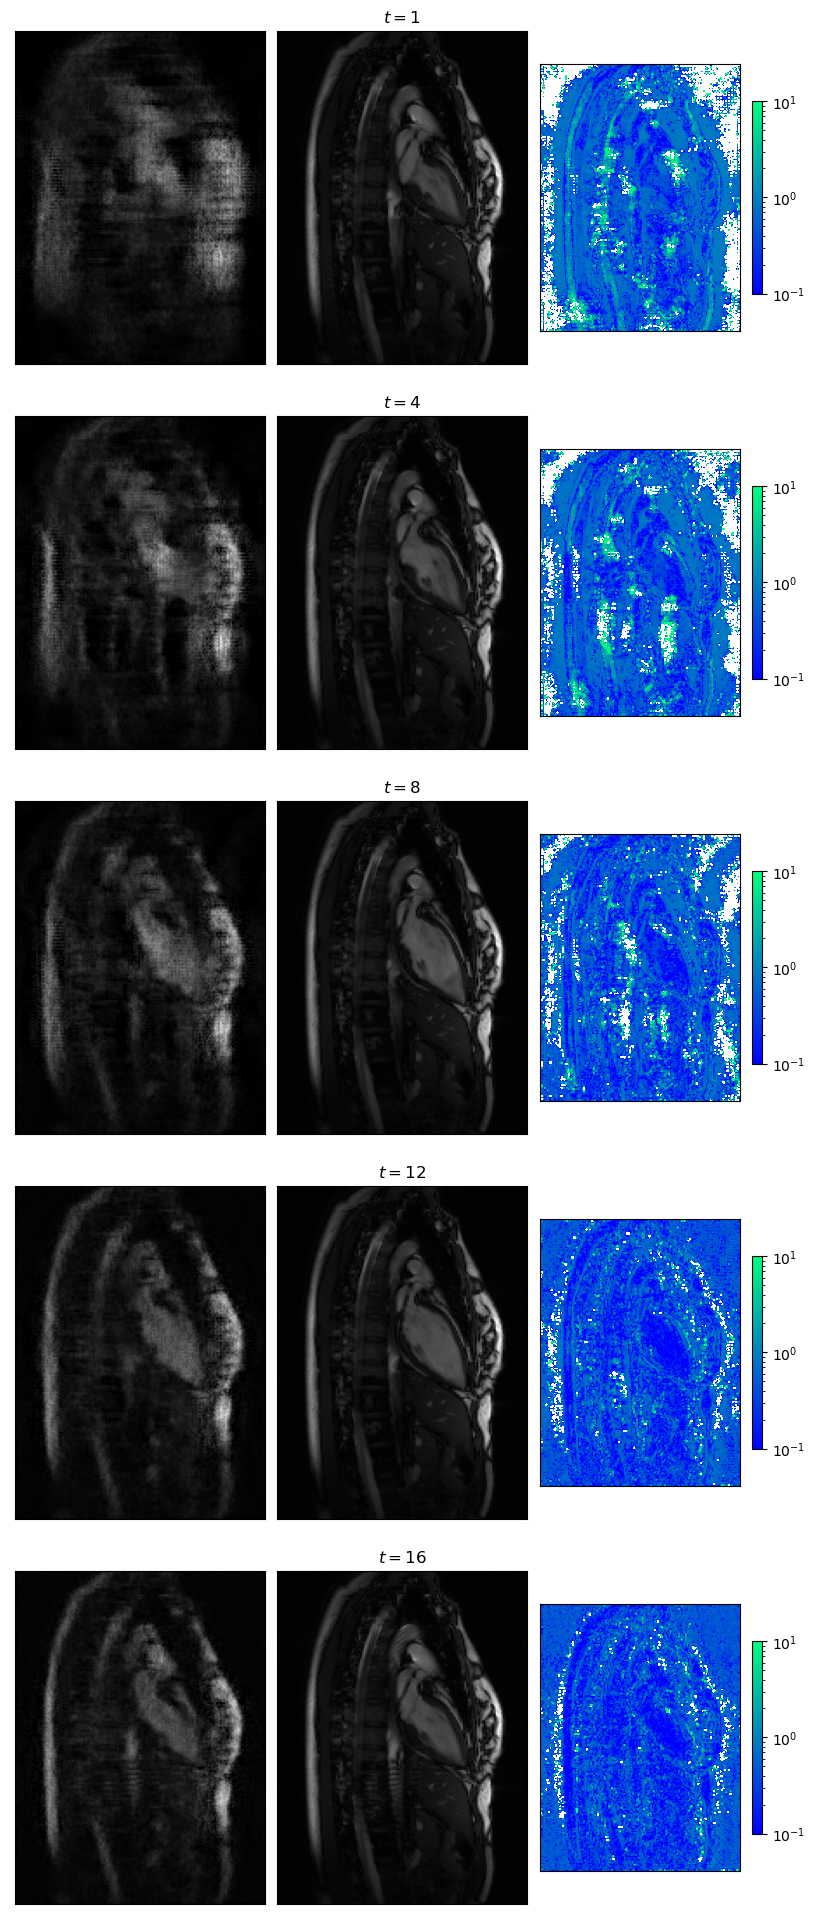

In [45]:
figsize = (10,25)
nrows = 5
ncols = 3
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)

window_large = 300
window_small = 300

frame = np.linspace(0,T-1,nrows).astype(int)
for i in range(nrows):
    axs[i,0].imshow(gts[frame[i]],vmin=0,vmax=1,cmap='gray')
    axs[i,1].set_title(fr'$t={frame[i]+1}$')
    axs[i,1].imshow(recons[frame[i]],vmin=0,vmax=1,cmap='gray')
    hdl = axs[i,2].imshow(abs(recons[frame[i]]-gts[frame[i]])/gts[frame[i]] , norm=colors.LogNorm(vmin=0.1,vmax=10), cmap='winter')
    fig.colorbar(hdl, ax=axs[i,2], location='right', anchor=(0, 0.5), shrink=0.5)

for i in range(nrows):
    for j in range(ncols):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

figname = '/home/ec2-user/SageMaker/RLsamp/figures/REINFORCE_recon_example.pdf'
# plt.savefig(figname, bbox_inches='tight', 
#                transparent=True)

plt.subplots_adjust(wspace=.05, hspace=0)
plt.show()

In [ ]:
ncfiles = np.load('/home/ec2-user/SageMaker/RLsamp/test_files.npz')['files']
t_backtrack = 8
datapath = '/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/'
loader  = ocmrLoader(ncfiles,batch_size=1,datapath=datapath,t_backtrack=t_backtrack,train_mode=False)


In [ ]:
loader.reset()

In [ ]:
file = 'fs_0021_3T.pt'  # pick an example file
data = torch.load(datapath+file)
print(data.shape)

In [ ]:
# Show the reconstructed cine image
from IPython.display import clear_output
import time

slc_idx = 0 # math.floor(SLC/2)
print(slc_idx)
for rep in range(5): # repeat the movie for 5 times
    for frame in range(data.shape[3]):
        clear_output(wait=True)
        plt.imshow(data[:,:,0,frame,0,slc_idx,:], vmin=0, vmax=data.max(), cmap = 'gray'); plt.axis('off');
        plt.colorbar()
        plt.show() 
        time.sleep(0.03)

In [ ]:
figsize = (15,15)
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=figsize)

window_large = 300
window_small = 300

axs[0,0].plot(rolling_mean(data['training_record']['poly_loss'], window_large))
axs[0,0].set_title('policy network running loss')

axs[0,1].plot(rolling_mean(data['training_record']['poly_grad_norm'],window_small))
axs[0,1].set_title('policy network gradient norm')
axs[0,2].set_yscale('log')

axs[0,2].plot(rolling_mean(data['training_record']['action_prob'],window_small))
axs[0,2].set_title('action probability')

axs[1,0].plot(rolling_mean(data['training_record']['horizon_rewards'],window_large))
axs[1,0].set_title('Horizon Rewards')


# axs[1,1].plot(rolling_mean(data['training_record']['poly_grad_norm'],window_large))
# axs[1,1].set_title('polynet Grad Norm')
# # axs[1,1].set_yscale('log')

# axs[1,2].plot(rolling_mean(data['training_record']['val_grad_norm'],window_large))
# axs[1,2].set_title('valnet Grad Norm')
# axs[1,2].set_yscale('log')

axs[1,1].plot(rolling_mean(data['training_record']['rmse'],window_small), label='RL')
axs[1,1].plot(rolling_mean(data['training_record']['rmse_rand'],window_small), label='rand')
axs[1,1].plot(rolling_mean(data['training_record']['rmse_lowfreq'],window_small), label='lowfreq.')
axs[1,1].set_title('RMSE - recon')
axs[1,1].legend(loc='best')
# axs[0,1].set_yscale('log')

axs[1,2].axis('off')

gt = axs[2,0].imshow(data['training_record']['recon_samples'][-1][0][0,0,:,:], origin='lower')
axs[2,0].set_title('Target gt')
fig.colorbar(gt, ax=axs[2,0], location='right', anchor=(0, 0.3), shrink=0.7)

recon = axs[2,1].imshow(data['training_record']['recon_samples'][-1][1][0,0,:,:], origin='lower')
axs[2,1].set_title('Recon')
fig.colorbar(recon, ax=axs[2,1], location='right', anchor=(0, 0.3), shrink=0.7)

rel_error = axs[2,2].imshow((data['training_record']['recon_samples'][-1][1][0,0,:,:] - data['training_record']['recon_samples'][-1][0][0,0,:,:])/data['training_record']['recon_samples'][-1][0][0,0,:,:],
                            origin='lower', norm=colors.LogNorm())
axs[2,2].set_title('Relative Error')
fig.colorbar(rel_error, ax=axs[2,2], location='right', anchor=(0, 0.3), shrink=0.7)

plt.show()